<a href="https://colab.research.google.com/github/adarshnitt/Deep-Learning-Models/blob/main/Filter%20Analysis%20of%20Deep%20Classification%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification

This tutorial shows how to classify images of flowers using a `tf.keras.Sequential` model and load data using `tf.keras.utils.image_dataset_from_directory`. It demonstrates the following concepts:


* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

In addition, the notebook demonstrates how to convert a [saved model](../../../guide/saved_model.ipynb) to a [TensorFlow Lite](https://www.tensorflow.org/lite/) model for on-device machine learning on mobile, embedded, and IoT devices.

## Setup

Import TensorFlow and other necessary libraries:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from pathlib import Path
import cv2

## Download and explore the dataset

Dataset is stored in virtual directory:<br>
This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [ ]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

228813984/228813984 [==============================] - 2s 0us/step


In [ ]:
# path of virtual machine data storage
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Here are some roses:

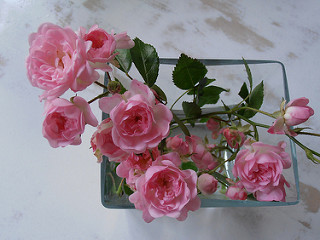

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

In [ ]:
str(roses[0])

'/root/.keras/datasets/flower_photos/roses/9159362388_c6f4cf3812_n.jpg'

And some tulips:

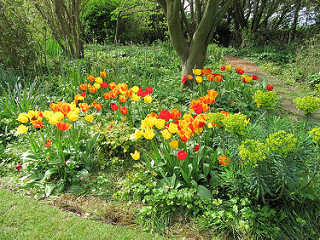

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

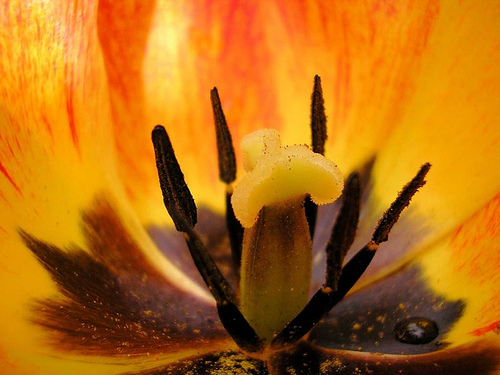

In [ ]:
PIL.Image.open(str(tulips[1]))

## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first nine images from the training dataset:

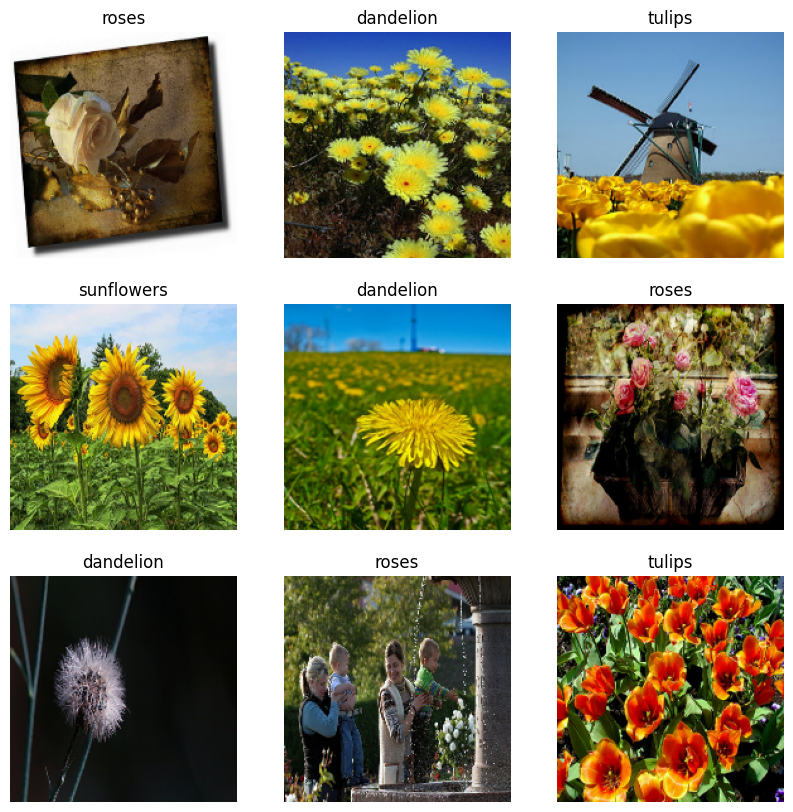

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [ ]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.008872573 0.7322078


Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [ ]:
num_classes = len(class_names)
filter_size=3
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, filter_size, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, filter_size, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, filter_size, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 98s 1s/step - loss: 1.3173 - accuracy: 0.4353 - val_loss: 1.1245 - val_accuracy: 0.5395
Epoch 2/10
92/92 [==============================] - 87s 953ms/step - loss: 1.0099 - accuracy: 0.6069 - val_loss: 1.0011 - val_accuracy: 0.5940
Epoch 3/10
92/92 [==============================] - 92s 999ms/step - loss: 0.8584 - accuracy: 0.6751 - val_loss: 1.0012 - val_accuracy: 0.5790
Epoch 4/10
92/92 [==============================] - 91s 989ms/step - loss: 0.6910 - accuracy: 0.7381 - val_loss: 0.8601 - val_accuracy: 0.6526
Epoch 5/10
92/92 [==============================] - 86s 941ms/step - loss: 0.5194 - accuracy: 0.8103 - val_loss: 0.9460 - val_accuracy: 0.6431
Epoch 6/10
92/92 [==============================] - 92s 996ms/step - loss: 0.3478 - accuracy: 0.8815 - val_loss: 1.0215 - val_accuracy: 0.6362
Epoch 7/10
92/92 [==============================] - 92s 997ms/step - loss: 0.1851 - accuracy: 0.9441 - val_loss: 1.1258 - val_accuracy: 0.6608
Ep

<h1> Layer Aalysis</h1>

In [ ]:
model.save("mymodel1")

In [ ]:
new_model = tf.keras.models.load_model('mymodel1')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

image shape:  (180, 180, 3)


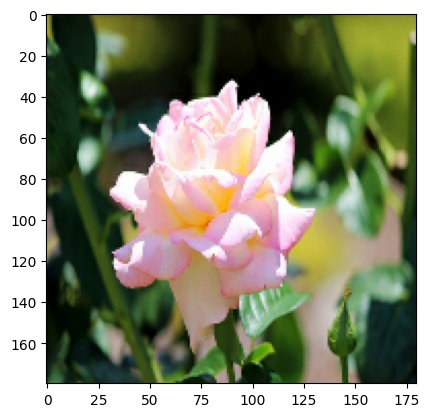

In [ ]:
for images, labels in train_ds.take(1):
  plt.imshow(images[0].numpy().astype("uint8")/255)
  full_img=images[0].numpy().astype("uint8")/255
  print("image shape: ",full_img.shape)


class main:
  def __init__(self,layer_no,img_channel,filter_channel,full_img,filter_size=3):
    self.img_channel=img_channel
    self.layer_no=layer_no
    self.img=full_img
    self.filter_size=filter_size
    self.filter_channel=filter_channel
    self.total_filter=0
    print("self.img_channel :",self.img_channel, " self.layer_no :",self.layer_no," self.filter_channel no: ",self.filter_channel)
    plt.subplot(1,3,1)
    plt.imshow(self.img)
    plt.title("Original Image ")
    plt.ylabel("Filter no : "+str(self.filter_channel))
  def weight_layer(self):
    # weight matrix for full layer no
    filter_matrix=np.array(new_model.layers[self.layer_no].get_weights()[0])
    self.total_filter=filter_matrix.shape[-1]
    return  filter_matrix
  def partial_img(self):
    partial_img1=self.img[:,:,self.img_channel]
    plt.subplot(1,3,2)
    plt.imshow(partial_img1)
    plt.title("img without filter")
    return partial_img1
  def partial_filter(self):
    partial_filter1=self.weight_layer()[:,:,self.img_channel,self.filter_channel]
    return partial_filter1
  def amplify( self):
    a=[]
    img1=self.partial_img()
    filt1=self.partial_filter()
    for i in range(0,img1.shape[0]-self.filter_size+1):
      a.append([])
      for j in range(0,self.img.shape[0]-self.filter_size+1):
        img11=img1[i:i+1,j:j+3]
        out11=(img11*filt1).sum()
        a[i].append(out11)
    plt.subplot(1,3,3)
    plt.imshow(a)
    plt.title("img and filter")
    return np.array(a)

class main1(main):
  def go(self):
    for i in range(self.total_filter):
      plt.figure( figsize=(10,5))
      self.amplify()


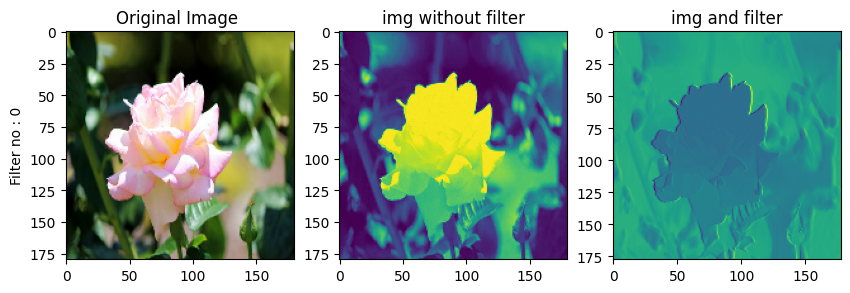

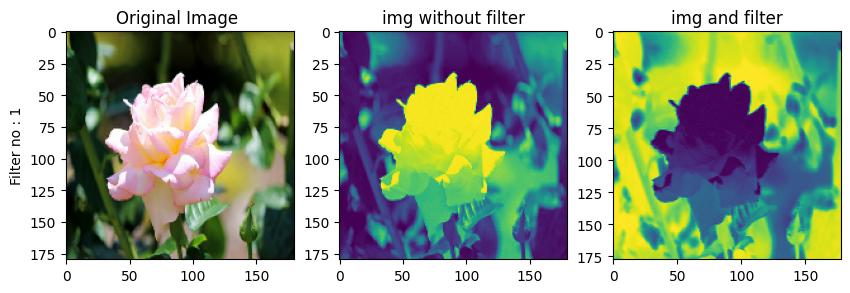

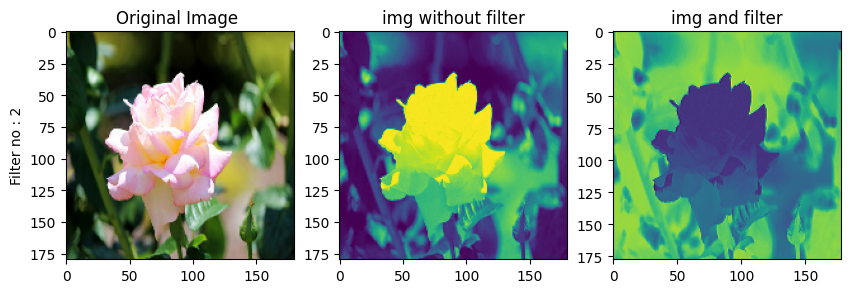

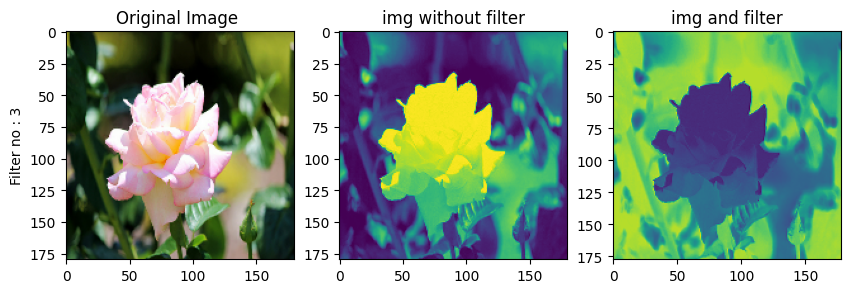

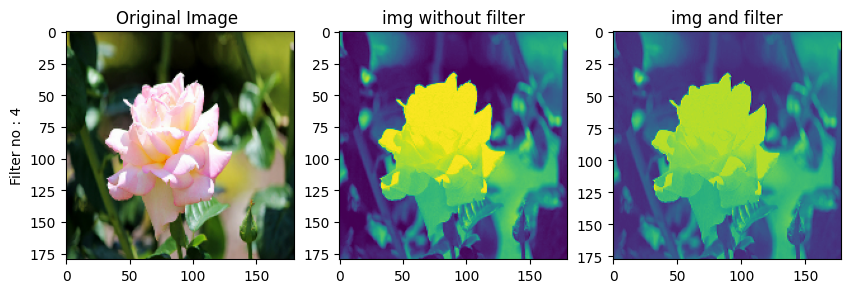

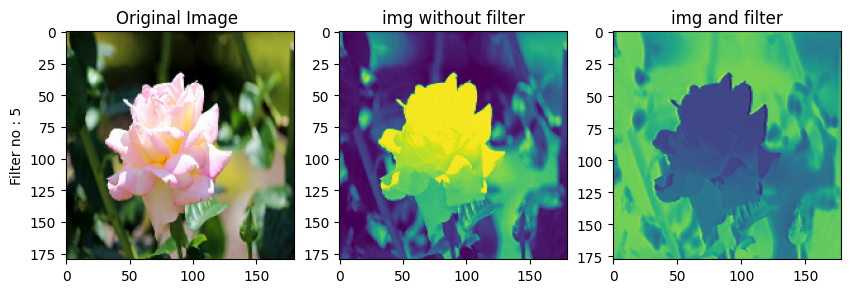

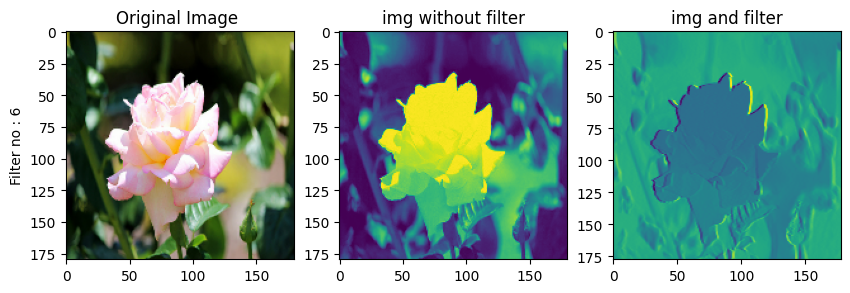

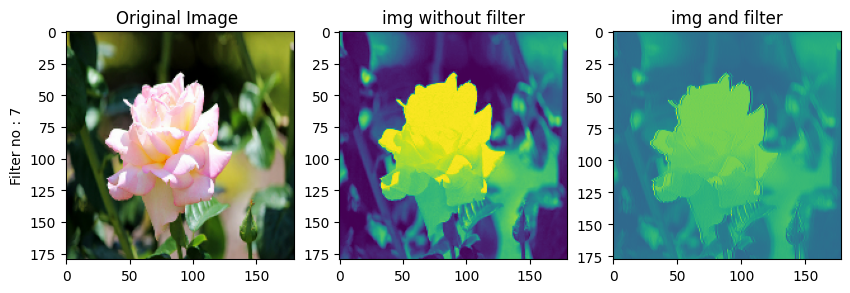

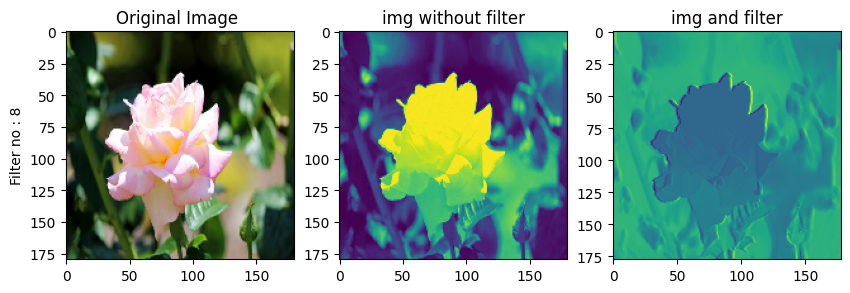

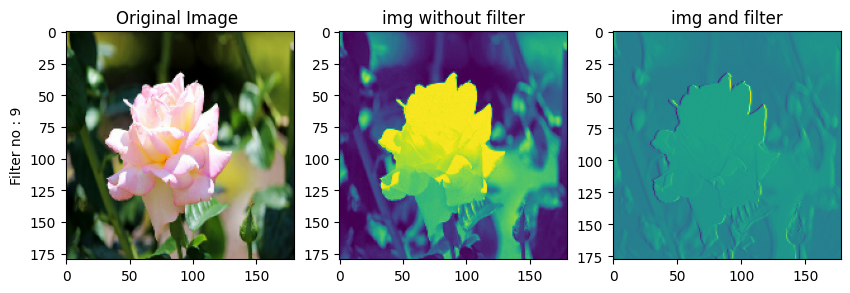

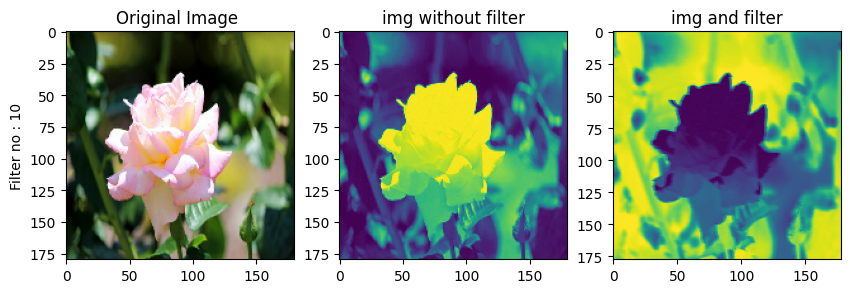

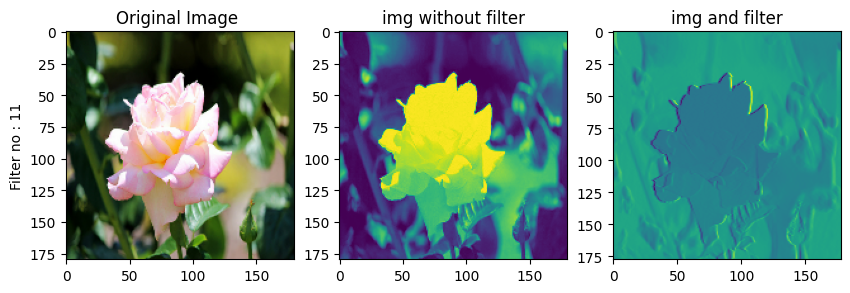

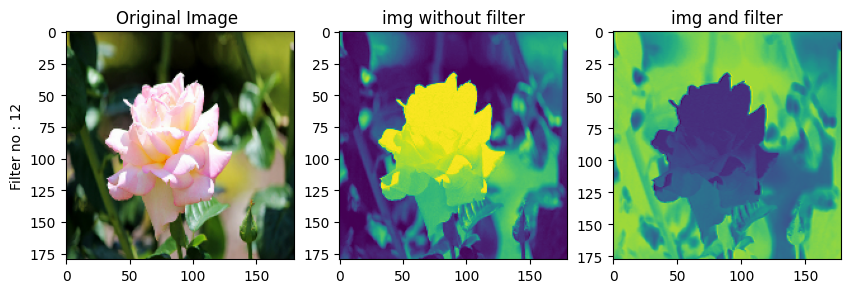

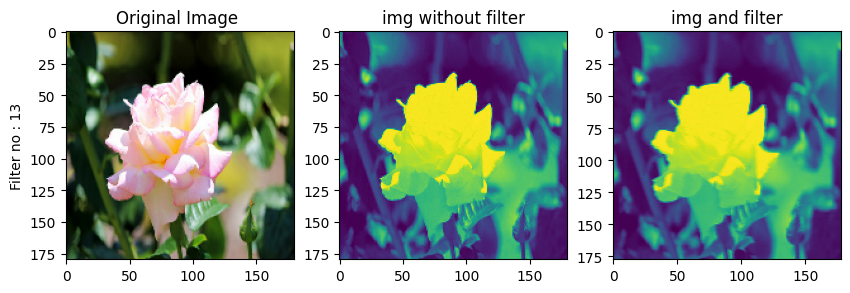

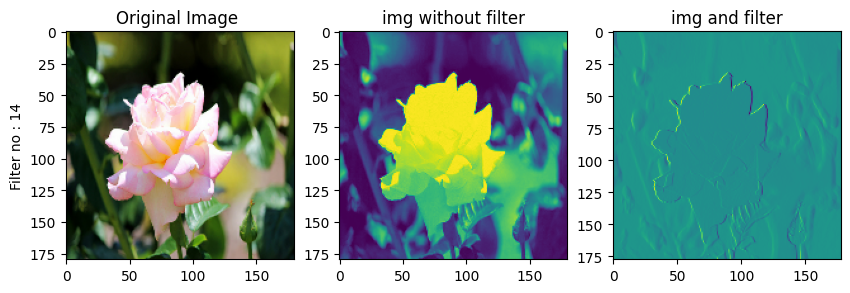

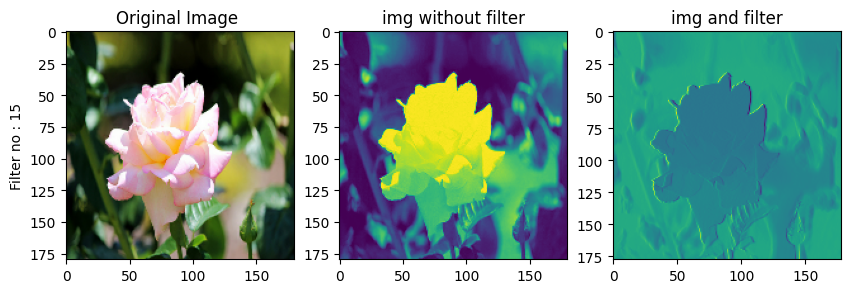

In [ ]:
layer_no=1
n=np.array(new_model.layers[layer_no].get_weights()[0]).shape[-1]

#0:r,1:g,2:b
img_channel=0
#if n filters are there then , which filter use, (3,3,64): 3* filter with total 64 filters, here filter_channel can values between 0 and 64
filter_channel=1


for i in range(n):
      plt.figure( figsize=(10,5))
      main(layer_no=layer_no,img_channel=img_channel,filter_channel=i,full_img=full_img,filter_size=3).amplify()

64